# Notebook 5: Use GraphStorm APIs for Graph Prediction

Graph prediction, such as classification and regression, is a common task in Graph Machine Learning (GML) across various domains, including life sciences and chemistry. In graph prediction, the entire graph data is typically organized into batches of subgraphs, where each subgraph's nodes have edges only within the subgraph and no edges connecting to nodes in other subgraphs. GML labels are linked to these subgraphs. And then GML model makes prediction on new subgraphs as well.

A typical operation used in graph prediction is called `Read-out`, e.g., `sum`, `mean`, or `max/min`, which aggregates the representations of nodes in a subgraph to form one representation for the subgraph. Outputs of the `Read-out` will be further used to perform downstream prediction computation.

<img src="../../../../tutorial/GP_readout.png" style="margin:auto" width="400"/>

The current version of GraphStorm can not directly perform graph prediction. But as GraphStorm supports node-level prediction, we can use a method called `supernode` to fulfill the graph prediction requirement.

----

## `super-node` Method Explanation

Instead of use the `Read-out` operation, we add a new node, called **super node**, 



This notebook will demonstrate the supernode method with 

1. uses a dummy data that contains hundreds of subgraphs and a set of supernodes, each of which contact to all nodes in one subgraph with in-degree edges so that only have messages passing into supernodes, but not back.
2. GraphStorm's data APIs, trainer and inferrer APIs.
3. A customized RGCN model that implement a Graph Classification-like method based on the "supernode" graph structure. **This RGCN model takes GraphStorm's graph conv layers as one of the arguments, therefore having the flexibility to change different base models for Graph Classification, which is considered as Option 2.**

This notebook serves as an example of a Graph Classification Solution using current version of GrahpStorm. Users can modify the customer GNN model and implement their own version.
This notebook then run Option 2 solution on the converted OGBG-molhiv data.

---

## 1. The OGBG-molhiv supernode graph

With the converted molhiv raw data tables, we run GraphStorm's gconstruct command and partition the graph into one partition. The processed graph is stored in `/data/gc_solution/dataset/ogbg_molhiv/gs_1p`.

In [1]:
!python -m graphstorm.gconstruct.construct_graph \
        --conf-file /data/gc_solution/dataset/ogbg_molhiv/gs_raw/config.json \
        --output-dir /data/gc_solution/dataset/ogbg_molhiv/gs_1p/ \
        --num-parts 1 \
        --graph-name molhiv

INFO:root:The graph has 2 node types and 2 edge types.
INFO:root:Node type node has 1049163 nodes
INFO:root:Node type super has 41127 nodes
INFO:root:Edge type ('node', 'to', 'node') has 2259376 edges
INFO:root:Edge type ('node', 'to_super', 'super') has 1049163 edges
INFO:root:Node type node has features: ['feat'].
INFO:root:Node type super has features: ['feat', 'train_mask', 'val_mask', 'test_mask', 'labels'].
INFO:root:Train/val/test on super: 32901, 4113, 4113
Converting to homogeneous graph takes 0.027s, peak mem: 8.348 GB
Save partitions: 0.524 seconds, peak memory: 8.348 GB
There are 3308539 edges in the graph and 0 edge cuts for 1 partitions.
INFO:root:Graph construction generates new node IDs for 'node'. The ID map is saved in /data/gc_solution/dataset/ogbg_molhiv/gs_1p/node_id_remap.parquet.
INFO:root:Graph construction generates new node IDs for 'super'. The ID map is saved in /data/gc_solution/dataset/ogbg_molhiv/gs_1p/super_id_remap.parquet.


In [2]:
# ogbg-molhiv input data config:
graph_config = '/data/gc_solution/dataset/ogbg_molhiv/gs_1p/molhiv.json'

## 2. Customized RGCN Encoder Module Using Conv Layers

The key component of this super-node based solution is the modification of the GNN model that can perform message passing and aggregation in each subgraph, then perform sorts of "read-out" operation in the super nodes, and finally perform classification on those super-nodes.

This option uses GraphStorm's [RelGraphConvLayer](https://graphstorm.readthedocs.io/en/latest/generated/graphstorm.model.RelGraphConvLayer.html#graphstorm.model.RelGraphConvLayer) API as one of the input arguments, and implement an customzied RGCN model for graph classification task.

Using this option, users can change the graph conv layer type, hence forming different GCN models.

In [3]:
import torch as th
from graphstorm.model import (GSgnnNodeModel,
                              GSNodeEncoderInputLayer,
                              RelationalGCNEncoder,
                              RelationalGATEncoder,
                              HGTEncoder,
                              EntityClassifier,
                              ClassifyLossFunc)
from graphstorm.model.gnn_encoder_base import GraphConvEncoder

In [4]:
class GCNEncoder4GC(GraphConvEncoder):
    r"""A graph conv encoder for Graph Classification

        Unique arguments in this class:
        -------------------------------
        base_encoder: GraphStorm ConvEncoder types, options:
            1. `RelationalGCNEncoder`;
            2. `RelationalGATEncoder`;
            3. `HGTEncoder`.
        read_out_opt: string in the following options:
            The aggregation method for the cached supernodes' representations. The current options:
            1. `last_only`: only use the last layer's representations. If use this option, 
               the read_out_ops will be ignored because there is only one layer representation
               is involved in the final read_out.
            2. `mean`: compute the mean of all of the cached supernode representations.
            3. `sum`: compute the summantion of all of the cached supernode representations.
            4. `weighted_sum`: use additional weight parameters to compute the weighted summation
               all of the cached supernode representations.
            5. `min`: compute the minimum in each dimension of the all of the cached supernode
               representations.
            6. `max`: compute the maximum in each dimension of the all of the cached supernode
               representations.
        super_ntype: string
            The name of supernode. Default is 'super'.
            
    """
    def __init__(self,
                 h_dim,
                 out_dim,
                 base_encoder,
                 read_out_opt='last_only',
                 super_ntype='super'
                ):
        assert isinstance(base_encoder, (RelationalGCNEncoder, RelationalGATEncoder, HGTEncoder)), \
               'Only support GraphStorm\'s RelationalGCNEncoder, RelationalGATEncoder, and HGTEncoder'
        assert base_encoder.num_layers >= 3, 'For Graph Classification task, at least two layers GNN' + \
                                       f'encoder required, but got {num_hidden_layers} ...'
        
        super(GCNEncoder4GC, self).__init__(h_dim, out_dim, base_encoder.num_layers)
        
        assert read_out_opt in ['last_only', 'mean', 'sum', 'weighted_sum', 'min', 'max'], + \
                                f'Not recognized read_out_opt {read_out_opt}. Options include ' + \
                                '\'last_only\', \'mean\', \'sum\', \'weighted_sum\', \'mim\', ' + \
                                'and \'max\'.'
        self.base_encoder = base_encoder
        self.read_out_opt = read_out_opt
        self.super_ntype = super_ntype
        if read_out_opt=='weighted_sum':
            self.weighted_sum_para = th.nn.Parameter(th.Tensor(1, num_hidden_layers))

    def forward(self, blocks, h):

        supernode_cache = []

        # message passing in subgraphs and cache super-nodes representations
        for layer, block in zip(self.base_encoder.layers, blocks):
            h = layer(block, h)
            
            # 1. cache the output of supernodes in each layer
            supernode_cache.append(h[self.super_ntype])
            # 2. zero out the representations of supernodes as the next layer input
            h[self.super_ntype] = th.zeros_like(h[self.super_ntype])

        # add final read_out functions.
        supernode_cache = th.stack(supernode_cache)
        output = self._read_out_ops(supernode_cache)
        
        return {self.super_ntype: output}

    def _read_out_ops(self, supernode_cache):
        """ The supernode_cache shape L * N * D
            The output shape N * D
        """
        if self.read_out_opt=='last_only':
            output = supernode_cache[-1]
        elif self.read_out_opt=='mean':
            output = th.mean(supernode_cache, dim=0)
        elif self.read_out_opt=='sum':
            output = th.sum(supernode_cache, dim=0)
        elif self.read_out_opt=='weighted_sum':
            output = th.einsum('ij, jkl->kl', self.weighted_sum_para, supernode_cache)

        return output

    # @property
    # def in_dims(self):
    #     return self.base_encoder.in_dims
    # @property
    # def out_dims(self):
    #     return self.base_encoder.out_dims

## 3. Training and Inference Pipeline

With the customized RGCN model modified for graph classification, we can reuse GraphStorm's end-to-end training and inference pipeline to conduct the graph classification task on our dummy data.

In [5]:
import os
import graphstorm as gs
from graphstorm.trainer import GSgnnNodePredictionTrainer
from graphstorm.dataloading import (GSgnnNodeTrainData,
                                    GSgnnNodeInferData,
                                    GSgnnNodeDataLoader)
from graphstorm.inference import GSgnnNodePredictionInferrer
from graphstorm.eval import GSgnnAccEvaluator

In [6]:
# initialize the graphstorm standalone environment
gs.initialize(ip_config=None, backend='gloo')
device = gs.utils.setup_device(0)

In [7]:
# config about the dataset and task for ogbg-molhiv data
graph_name = 'molhiv'
target_ntype = 'super'
node_feat_name = 'feat'
feat_sizes = {'node': 9, 'super': 16}
label_field = 'labels'
num_classes = 2
multilabel = False

# learning params:
batch_size = 256
lr = 0.001
sparse_optimizer_lr = 0.01
weight_decay = 0.

# model architecture:
hidden_size = 32
fanout = [20,20,20]
dropout = 0.0
num_bases = -1
num_layers = 3
use_self_loop = False

In [8]:
# load the constructed graph data
train_data = GSgnnNodeTrainData(
    graph_name=graph_name,
    part_config=graph_config,
    train_ntypes=target_ntype,
    eval_ntypes=target_ntype,
    node_feat_field=node_feat_name,
    label_field=label_field)

In [9]:
# train_data.g stores a DistGraph object
print('Number of nodes:')
for ntype in train_data.g.ntypes:
    print(f'- {ntype}: {train_data.g.num_nodes(ntype)}')
print('Number of edges:')
for etype in train_data.g.etypes:
    print(f'- {etype}: {train_data.g.num_edges(etype)}')

Number of nodes:
- node: 1049163
- super: 41127
Number of edges:
- to: 2259376
- to_super: 1049163


In [10]:
# set up data loaders
dataloader = GSgnnNodeDataLoader(
    train_data, train_data.train_idxs, fanout=fanout,
    batch_size=batch_size,
    device=device, train_task=True)

val_dataloader = GSgnnNodeDataLoader(
    train_data, train_data.val_idxs, fanout=fanout,
    batch_size=batch_size,
    device=device, train_task=False)

test_dataloader = GSgnnNodeDataLoader(
    train_data, train_data.test_idxs, fanout=fanout,
    batch_size=batch_size,
    device=device, train_task=False)

### Use the customized RGCN encoder

A GSF model should contain the following components: 
- Input encoder for nodes (and optionally edges): process and project input features and embeddings into a certain dimension
- GNN encoder: performs message-passing on projected node/edge inputs, which is replaced with our customized RGCN encoder
- Decoder: specific for tasks on the graph

In the following codes, we set up a `GSgnnNodeModel` model composed of `GSNodeEncoderInputLayer`, `GCNEncoder4GC`, `EntityClassifier` step-by-step.

Users can try out your own components to replace these modules.

In [11]:
# create a gsf model
model = GSgnnNodeModel(alpha_l2norm=0.)

# set input layer encoder
encoder = GSNodeEncoderInputLayer(
    train_data.g,
    feat_sizes,
    hidden_size,
    dropout=dropout,
    activation=None)
print(f'Input output dims: {encoder.out_dims}')
model.set_node_input_encoder(encoder)

# set base gcn encoder
gnn_encoder = RelationalGCNEncoder(
    train_data.g,
    hidden_size,
    hidden_size,
    num_bases,
    num_hidden_layers=num_layers,
    dropout=dropout,
    use_self_loop=use_self_loop)
print(f'Base encoder input dims: {gnn_encoder.in_dims}')
# wrap base gcn encoder into GCNEncoder4GC
gc_encoder = GCNEncoder4GC(hidden_size,
                           hidden_size,
                           gnn_encoder,
                           read_out_opt='last_only',
                           super_ntype='super')
model.set_gnn_encoder(gc_encoder)

# set decoder specific to node-classification task
model.set_decoder(EntityClassifier(
    model.node_input_encoder.out_dims,
    num_classes, 
    multilabel))
# classification loss function
model.set_loss_func(ClassifyLossFunc(multilabel))

model.init_optimizer(
    lr=lr, 
    sparse_optimizer_lr=sparse_optimizer_lr,
    weight_decay=weight_decay
    )

model

Input output dims: 32
Base encoder input dims: 32


GSgnnNodeModel(
  (_node_input_encoder): GSNodeEncoderInputLayer(
    (dropout): Dropout(p=0.0, inplace=False)
    (proj_matrix): ParameterDict()
    (input_projs): ParameterDict(
        (node): Parameter containing: [torch.FloatTensor of size 9x32]
        (super): Parameter containing: [torch.FloatTensor of size 16x32]
    )
    (ngnn_mlp): ModuleDict(
      (node): NGNNMLP(
        (dropout): Dropout(p=0.0, inplace=False)
        (ngnn_gnn): ParameterList()
      )
      (super): NGNNMLP(
        (dropout): Dropout(p=0.0, inplace=False)
        (ngnn_gnn): ParameterList()
      )
    )
  )
  (_gnn_encoder): GCNEncoder4GC(
    (_layers): ModuleList()
    (base_encoder): RelationalGCNEncoder(
      (_layers): ModuleList(
        (0-3): 4 x RelGraphConvLayer(
          (conv): HeteroGraphConv(
            (mods): ModuleDict(
              (('node', 'to', 'node')): GraphConv(in=32, out=32, normalization=right, activation=None)
              (('node', 'to_super', 'super')): GraphConv(in

### 3. Create a graphstorm trainer and train the model
The trainers is task-specific in graphstorm. It handles:
1. model training/evaluation loops
2. saving and restoring model checkpoints
3. early-stopping

The OGBG leaderboard uses `roc_auc` as the evaluation metric for the molhiv data because its labels are extremely unbalanced. Therefore, here we set the evaluator's `eval_metric` to be `roc_auc`. But due to a GraphStorm bug that fails to evaluate `f` and `auc` when handles binary classification, users need to modify the line 299 in `graphstorm/python/graphstorm/eval/eval_func.py` like the followings:

``` python
    try:
        if y_pred.shape[1] == 2:
            auc_score = roc_auc_score(y_true, y_pred[:, 1], sample_weight=weights, multi_class='ovr')
        else:
            auc_score = roc_auc_score(y_true, y_pred, sample_weight=weights, multi_class='ovr')
    except ValueError as e:
        logging.error("Failure found during evaluation of the auc metric returning -1: %s", str(e))
    return auc_score
```

In [12]:
# create a trainer for the model
trainer = GSgnnNodePredictionTrainer(
    model, 
    topk_model_to_save=1)

# set up device for the trainer
trainer.setup_device(device=device)

# set up evaluator for the trainer:
evaluator = GSgnnAccEvaluator(
    eval_frequency=5,
    eval_metric=['roc_auc'],
    multilabel=multilabel)

trainer.setup_evaluator(evaluator)

In [13]:
# Train the model with the trainer
trainer.fit(
    train_loader=dataloader, 
    val_loader=val_dataloader,
    test_loader=test_dataloader, 
    num_epochs=5,
    save_model_path='nc_model/',
)

/home/ubuntu/anaconda3/envs/gsf/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Next, we examine the model performance over the training process

In [14]:
# Extract accuracies from the trainer's evaluator:
val_accs, test_accs = [], []
for val_acc, test_acc in trainer.evaluator.history:
    val_accs.append(val_acc['roc_auc'])
    test_accs.append(test_acc['roc_auc'])

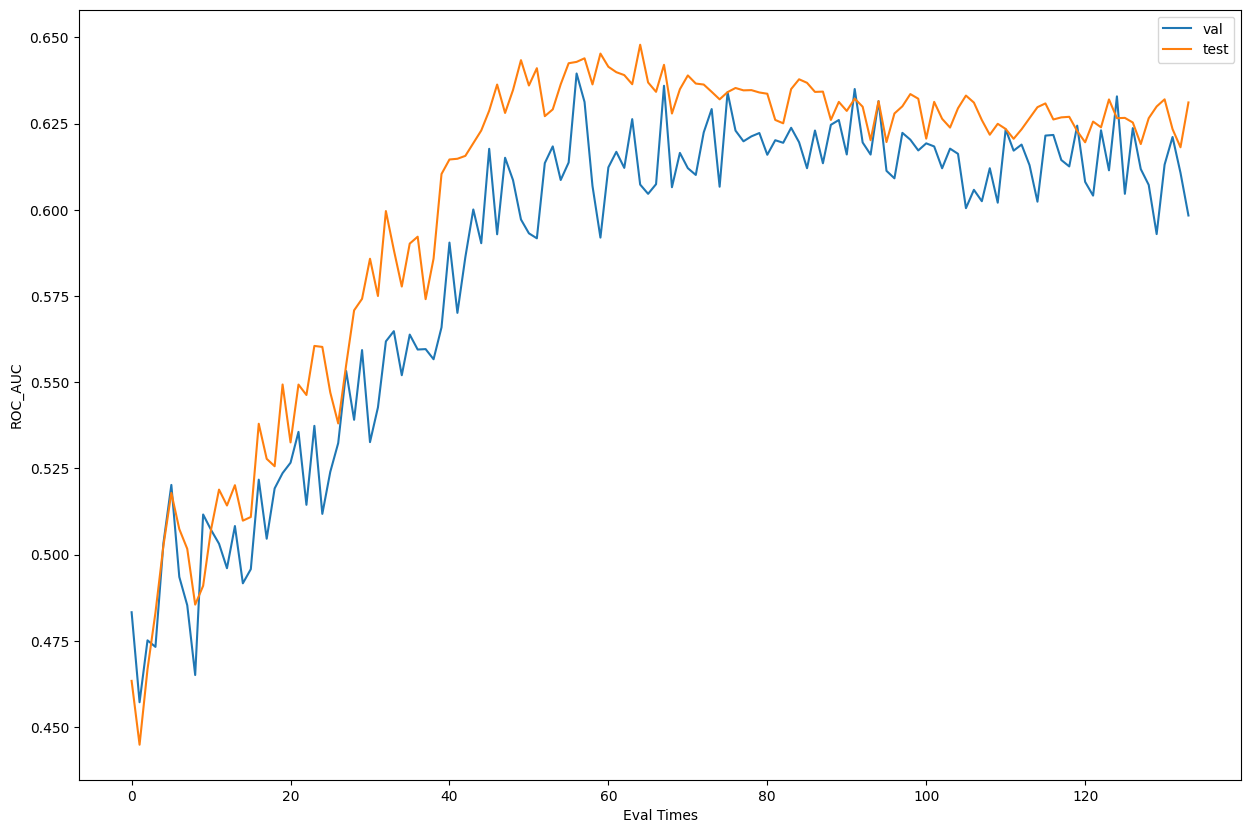

In [15]:
import matplotlib.pyplot as plt

# plot the learning curves
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(val_accs, label='val')
ax.plot(test_accs, label='test')
ax.set(xlabel='Eval Times', ylabel='ROC_AUC')
ax.legend(loc='best');

In [16]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model checkpoint:', best_model_path)

Best model checkpoint: nc_model/epoch-2


In [17]:
# check the saved artifacts
!ls -ls {best_model_path}

total 128
44 -rw-rw-r-- 1 ubuntu ubuntu 42391 Jan  8 21:34 model.bin
84 -rw-rw-r-- 1 ubuntu ubuntu 82914 Jan  8 21:34 optimizers.bin


### 3. Inference with the trained model

In [18]:
# we can restore the model from the checkpoint:
model.restore_model(best_model_path)

In [19]:
# Create a dataset for inference, we use the same MovieLens graph
infer_data = GSgnnNodeInferData(
    graph_name, 
    graph_config,
    eval_ntypes=target_ntype,
    node_feat_field=node_feat_name,
    label_field=label_field)

# Set up dataloader for the inference dataset
infer_dataloader = GSgnnNodeDataLoader(
    infer_data, infer_data.test_idxs, fanout=fanout, 
    batch_size=100, device=device,
    train_task=False)


# Create an Inferrer object
infer = GSgnnNodePredictionInferrer(model)
infer.setup_device(device=device)
infer.setup_evaluator(evaluator)


In [20]:
# Run inference on the inference dataset
infer.infer(infer_dataloader, 
            save_embed_path=os.path.join(best_model_path, 'infer/embeddings'),
            save_prediction_path=os.path.join(best_model_path, 'infer/predictions'),
            use_mini_batch_infer=True)

In [21]:
# The GNN embeddings on the inference graph are saved to:
!ls -lh {best_model_path}/infer/embeddings

total 8.0K
-rw-rw-r-- 1 ubuntu ubuntu   89 Jan  8 21:35 emb_info.json
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jan  8 21:35 super


In [22]:
!ls -lh {best_model_path}/infer/predictions

total 8.0K
-rw-rw-r-- 1 ubuntu ubuntu   87 Jan  8 21:35 result_info.json
drwxrw-rwx 2 ubuntu ubuntu 4.0K Jan  8 21:35 super
